In [1]:
import numpy as np
import gym
from gym import spaces
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque



In [2]:
class EnergyEnv(gym.Env):
    def __init__(self):
        super(EnergyEnv, self).__init__()

        # Action space: 0 - Use solar, 1 - Store in battery, 2 - Draw from battery, 3 - Draw from grid
        self.action_space = spaces.Discrete(4)

        # Observation space: [battery_level, solar_energy, load]
        self.observation_space = spaces.Box(low=np.array([1000, 0, 0]), high=np.array([10000, 3000, 1000]), dtype=np.float32)

        potental_number_of_days_without_solar = 1

        self.solar_energy = {
            'hour0': 0 * 1000 * potental_number_of_days_without_solar, 
            'hour1': 0 * 1000 * potental_number_of_days_without_solar, 
            'hour2': 0 * 1000 * potental_number_of_days_without_solar, 
            'hour3': 0 * 1000 * potental_number_of_days_without_solar, 
            'hour4': 0 * 1000 * potental_number_of_days_without_solar, 
            'hour5': 0 * 1000 * potental_number_of_days_without_solar, 
            'hour6': 0.15 * 1000 * potental_number_of_days_without_solar, 
            'hour7': 0.4 * 1000 * potental_number_of_days_without_solar, 
            'hour8': 0.6 * 1000 * potental_number_of_days_without_solar, 
            'hour9': 0.8 * 1000 * potental_number_of_days_without_solar, 
            'hour10': 0.9 * 1000 * potental_number_of_days_without_solar, 
            'hour11': 0.96 * 1000 * potental_number_of_days_without_solar, 
            'hour12': 0.98 * 1000 * potental_number_of_days_without_solar, 
            'hour13': 0.9 * 1000 * potental_number_of_days_without_solar, 
            'hour14': 0.75 * 1000 * potental_number_of_days_without_solar, 
            'hour15': 0.58 * 1000 * potental_number_of_days_without_solar, 
            'hour16': 0.37 * 1000 * potental_number_of_days_without_solar, 
            'hour17': 0.14 * 1000 * potental_number_of_days_without_solar, 
            'hour18': 0 * 1000 * potental_number_of_days_without_solar, 
            'hour19': 0 * 1000 * potental_number_of_days_without_solar, 
            'hour20': 0 * 1000 * potental_number_of_days_without_solar, 
            'hour21': 0 * 1000 * potental_number_of_days_without_solar, 
            'hour22': 0 * 1000 * potental_number_of_days_without_solar, 
            'hour23': 0 * 1000 * potental_number_of_days_without_solar
        }

        self.load = {
            'hour0': 0.08 * 1000, 'hour1': 0.07 * 1000, 'hour2': 0.07 * 1000, 'hour3': 0.07 * 1000, 
            'hour4': 0.25 * 1000, 'hour5': 0.37 * 1000, 'hour6': 0.41 * 1000, 'hour7': 0.37 * 1000, 
            'hour8': 0.3 * 1000, 'hour9': 0.31 * 1000, 'hour10': 0.37 * 1000, 'hour11': 0.41 * 1000, 
            'hour12': 0.53 * 1000, 'hour13': 0.4 * 1000, 'hour14': 0.34 * 1000, 'hour15': 0.33 * 1000, 
            'hour16': 0.34 * 1000, 'hour17': 0.5 * 1000, 'hour18': 0.9 * 1000, 'hour19': 0.75 * 1000, 
            'hour20': 0.53 * 1000, 'hour21': 0.37 * 1000, 'hour22': 0.17 * 1000, 'hour23': 0.12 * 1000
        }

        self.battery_capacity = 10 * 1000  # Wh
        self.min_battery = 1 * 1000        # Minimum charge 10%
        self.max_battery = 10 * 1000       # Full charge
        
        # Set the initial hour, battery level, and grid usage
        self.current_hour = 0 
        self.battery_level = 2.35 * 1000  # Starting battery level in Wh
        
        self.grid_usage = 0  # Tracking how much energy is used from the grid
        
        self.battery_charge_and_discharge_rate = 5 * 1000  # Wh

    def reset(self):
        # Resetting environment to initial state
        self.current_hour = 0
        self.grid_usage = 0
        self.battery_level = 2.35 * 1000
        
        return np.array([self.battery_level, self.solar_energy['hour0'], self.load['hour0']], dtype=np.float32)

    def step(self, action):
        # Get solar energy and load for the current hour
        solar_energy = self.solar_energy[f'hour{self.current_hour}']
        load = self.load[f'hour{self.current_hour}']

        reward = 0
        grid_usage = 0
        demand_met = False
        surplus = 0

        # Action 0: Use solar energy to meet load demand
        if action == 0:
            if solar_energy >= load: # If demand is met
                wastage = solar_energy - load
                self.grid_usage += 0 # Do not draw from grid
                reward = load - wastage # Positive reward for meeting the load and not drawing from grid

            else: # If demand is not met
                load_deficit = load - solar_energy 
                self.grid_usage += load_deficit # Take energy deficit from grid
                self.battery_level += 0 # No surplus to save
                reward = -load_deficit # Negative reward for drawing energy from the grid

        # Action 1: Store in battery
        elif action == 1:
            if (self.battery_level + solar_energy) >= self.max_battery: # If charging exceeds battery capacity
                wastage = (self.battery_level + solar_energy) - self.max_battery 
                stored_energy = self.max_battery - self.battery_level
                self.battery_level = self.max_battery # Battery is full
                self.grid_usage += load
                reward = -load - wastage + stored_energy


            else: # If charging does not exceed battery capacity
                self.battery_level += solar_energy # Charge the battery
                stored_energy = solar_energy
                self.grid_usage += load # Grid carries the load when battery is charging
                reward = -load + stored_energy# Negative reward for drawing energy from the grid

        # Action 2: Draw from battery
        elif action == 2:
            if (self.battery_level - load) < self.min_battery: # If drawing from the battery drains it below min capacity
                if self.battery_level > self.min_battery: # Battery has some power to spare
                    available_battery_energy = self.battery_level - self.min_battery 
                    self.battery_level = self.min_battery 
                    self.grid_usage += load - available_battery_energy 
                    wastage = solar_energy
                    reward = -(load - available_battery_energy) - wastage # Negative reward for drawing energy from the grid
                else: # If the battery has no energy to spare
                    self.battery_level = self.min_battery 
                    self.grid_usage += load 
                    wastage = solar_energy
                    reward = -load - wastage # Negative reward for drawing energy from the grid
            else: # If drawing from the battery does not drain it
                self.battery_level -= load # Simply discharge
                self.grid_usage += 0 # Do not draw from grid
                wastage = solar_energy
                reward = load - wastage  # Positive reward for not drawing energy from the grid

        # Action 3: Draw from grid
        elif action == 3:
            self.battery_level -= 0 # Nothing happens to the battery
            self.grid_usage += load # Grid carries the load
            wastage = solar_energy
            punish_factor = 1 # Drawing energy directly from the grid is discouraged more than any other option
            reward = -load * punish_factor - wastage # Negative reward for drawing energy from the grid
            
        # Move to the next hour in the environment
        self.current_hour += 1
        done = self.current_hour == 24
        if self.current_hour == 24: # Reset after a day passes
            self.current_hour = 0

        # Observation at the next time step
        next_observation = np.array([self.battery_level, self.solar_energy[f'hour{self.current_hour}'], self.load[f'hour{self.current_hour}']], dtype=np.float32)

        

        return next_observation, reward, done, {}

    def render(self, mode='human'):
        print(f'Hour: {self.current_hour}, Battery Level: {self.battery_level}, Grid Usage: {self.grid_usage}')


In [3]:

class DQN(nn.Module):
    """Neural network for approximating Q-values."""
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_size)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class DQNAgent:
    def __init__(self, env, state_size, action_size, learning_rate=0.001, discount_factor=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01, batch_size=64):
        self.env = env
        self.state_size = state_size
        self.action_size = action_size
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.batch_size = batch_size
        self.memory = deque(maxlen=2000)

        # Initialize the DQN model and the target model
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        self.loss_fn = nn.MSELoss()

        # Initialize the target model weights with the same as the main model
        self.update_target_model()

    def update_target_model(self):
        """Update target network weights."""
        self.target_model.load_state_dict(self.model.state_dict())

    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay memory."""
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        """Choose the next action using epsilon-greedy strategy."""
        if np.random.rand() <= self.epsilon:
            return self.env.action_space.sample()  # Explore: random action
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.model(state_tensor)
            return torch.argmax(q_values).item()  # Exploit: choose best action

    def replay(self):
        """Train the DQN using experience replay."""
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            next_state_tensor = torch.FloatTensor(next_state).unsqueeze(0)
            target = reward
            if not done:
                target = reward + self.discount_factor * torch.max(self.target_model(next_state_tensor)).item()
            
            current_q_value = self.model(state_tensor)[0][action]
            loss = self.loss_fn(current_q_value, torch.tensor(target))
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

    def train(self, episodes=1000, max_steps=24, target_update_freq=10):
        """Train the DQN agent."""
        rewards = []
        grid_usage = []
        best_episode_reward = float('-inf')
        best_episode_actions = []

        for episode in range(episodes):
            state = self.env.reset()
            total_reward = 0
            total_grid_usage = 0
            actions = []

            for step in range(max_steps):
                action = self.choose_action(state)
                actions.append(action)
                next_state, reward, done, info = self.env.step(action)

                self.remember(state, action, reward, next_state, done)
                self.replay()
                state = next_state
                total_reward += reward
                total_grid_usage += info.get('grid_usage', 0)
                
                if done:
                    break
            
            rewards.append(total_reward)
            grid_usage.append(total_grid_usage)

            if total_reward > best_episode_reward:
                best_episode_reward = total_reward
                best_episode_actions = actions

            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay

            # Update the target model periodically
            if episode % target_update_freq == 0:
                self.update_target_model()

            print(f'Episode {episode}, Total Reward: {total_reward}, Grid Usage: {total_grid_usage}, Epsilon: {self.epsilon}')

        self.best_actions = best_episode_actions
        return rewards, grid_usage



In [4]:

# Initialize the environment and DQN agent
env = EnergyEnv()
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
dqn_agent = DQNAgent(env, state_size, action_size, learning_rate=0.001, discount_factor=0.95, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01)

# Train the agent and get rewards and grid usage data
rewards, grid_usage = dqn_agent.train(episodes=2000)






C:\Users\Revaldo Nkwinika\anaconda3\Lib\site-packages\gym\spaces\box.py:127: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


Episode 0, Total Reward: -4200.0, Grid Usage: 0, Epsilon: 0.995
Episode 1, Total Reward: -5610.0, Grid Usage: 0, Epsilon: 0.990025
Episode 2, Total Reward: -3690.0, Grid Usage: 0, Epsilon: 0.985074875
Episode 3, Total Reward: 140.0, Grid Usage: 0, Epsilon: 0.9801495006250001
Episode 4, Total Reward: -5350.0, Grid Usage: 0, Epsilon: 0.9752487531218751
Episode 5, Total Reward: -9880.0, Grid Usage: 0, Epsilon: 0.9703725093562657
Episode 6, Total Reward: -5890.0, Grid Usage: 0, Epsilon: 0.9655206468094844
Episode 7, Total Reward: -4520.0, Grid Usage: 0, Epsilon: 0.960693043575437
Episode 8, Total Reward: -7920.0, Grid Usage: 0, Epsilon: 0.9558895783575597
Episode 9, Total Reward: -8930.0, Grid Usage: 0, Epsilon: 0.9511101304657719
Episode 10, Total Reward: -11070.0, Grid Usage: 0, Epsilon: 0.946354579813443
Episode 11, Total Reward: -940.0, Grid Usage: 0, Epsilon: 0.9416228069143757
Episode 12, Total Reward: -3470.0, Grid Usage: 0, Epsilon: 0.9369146928798039
Episode 13, Total Reward: -497

In [5]:
# Visualization for Rewards
def plot_rewards(rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards, label="Total Reward per Episode", color='blue')
    plt.xlabel("Episodes")
    plt.ylabel("Total Reward")
    plt.title("DQN: Reward over Episodes")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_rewards(rewards)

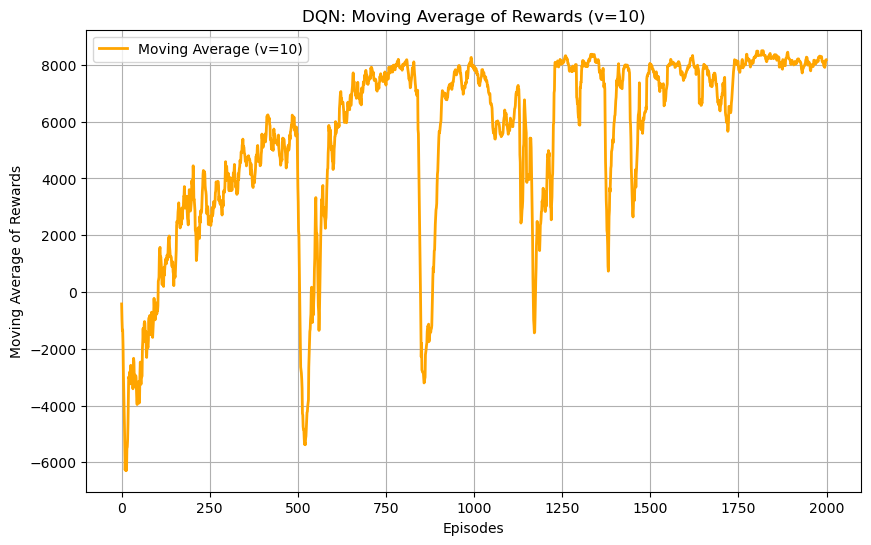

In [6]:

def plot_moving_average(rewards, v=10):
    """Plot the moving average of rewards over episodes."""
    # Calculate the moving average
    moving_avg = []
    for i in range(len(rewards)):
        # Get the slice of the previous v episodes including the current one
        relevant_rewards = rewards[max(0, i - v + 1):i + 1]
        # Pad with zeros if there are fewer than v episodes
        while len(relevant_rewards) < v:
            relevant_rewards.insert(0, 0)  
        # Compute the average
        moving_avg.append(np.mean(relevant_rewards))
    
    # Plotting the moving average
    plt.figure(figsize=(10, 6))
    plt.plot(moving_avg, label=f"Moving Average (v={v})", color='orange', linewidth=2)
    plt.xlabel("Episodes")
    plt.ylabel("Moving Average of Rewards")
    plt.title(f"DQN: Moving Average of Rewards (v={v})")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_moving_average(rewards)


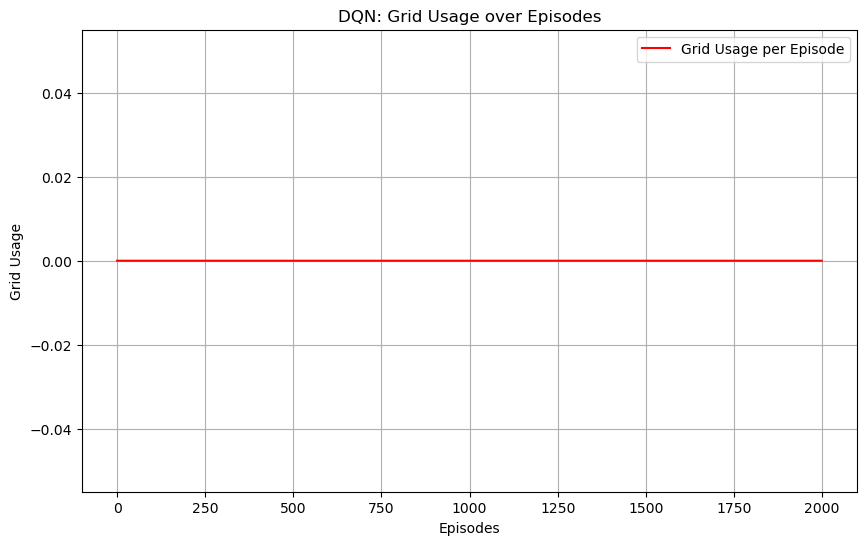

In [7]:
# Visualization for Grid Usage
def plot_grid_usage(grid_usage):
    plt.figure(figsize=(10, 6))
    plt.plot(grid_usage, label="Grid Usage per Episode", color='red')
    plt.xlabel("Episodes")
    plt.ylabel("Grid Usage")
    plt.title("DQN: Grid Usage over Episodes")
    plt.legend()
    plt.grid(True)
    plt.show()


plot_grid_usage(grid_usage)



In [8]:

# Visualize the actions over one episode
def visualize_policy(dqn_agent, state):
    actions = []
    state = env.reset()
    
    for _ in range(24):  # 24 hours
        action = dqn_agent.choose_action(state)
        actions.append(action)
        next_state, _, _, _ = env.step(action)
        state = next_state
    
    plt.figure(figsize=(10, 6))
    plt.plot(actions, label="Actions Taken by Agent (0=Solar to House, 1=Solar to Battery, etc.)", marker='o')
    plt.xlabel("Hour (0-23)")
    plt.ylabel("Action")
    plt.title("DQN: Actions Taken Over 24 Steps")
    plt.legend()
    plt.grid(True)
    plt.show()

# Test the agent and visualize actions over 24 hours
visualize_policy(dqn_agent, env.reset())



In [9]:
# Translate best actions to human-readable descriptions
best_action_descriptions = dqn_agent.get_action_descriptions(dqn_agent.best_actions)

# Display the best actions in words
for i, description in enumerate(best_action_descriptions):
    print(f"Hour {i}: {description}")


AttributeError: 'DQNAgent' object has no attribute 'get_action_descriptions'

In [ ]:
# Track battery level and grid usage for 24 hours based on the best actions
def track_battery_and_grid_usage(env, best_actions):
    battery_levels = []  # Store battery level at each hour
    grid_usages = []     # Store grid usage at each hour

    state = env.reset()  # Reset environment to initial state
    for hour, action in enumerate(best_actions):
        # Take action and collect relevant data
        next_state, reward, done, info = env.step(action)
        
        # Record battery level and cumulative grid usage after each step
        battery_levels.append(env.battery_level)
        grid_usages.append(env.grid_usage)
        
        # Update state to the next one
        state = next_state
        if done:
            break

    # Plot battery levels over 24 hours
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(battery_levels)), battery_levels, marker='o', color='green', label='Battery Level (Wh)')
    plt.xlabel('Hour')
    plt.ylabel('Battery Level (Wh)')
    plt.title('Battery Level Over 24 Hours (Best Actions)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot grid usage over 24 hours
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(grid_usages)), grid_usages, marker='o', color='red', label='Grid Usage (Wh)')
    plt.xlabel('Hour')
    plt.ylabel('Cumulative Grid Usage (Wh)')
    plt.title('Cumulative Grid Usage Over 24 Hours (Best Actions)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to visualize battery level and grid usage for 24 hours
track_battery_and_grid_usage(env,dqn_agent.best_actions)
